In [29]:
import xarray as xr
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm

from isca_tools.convection.base import lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.thesis.lapse_theory import reconstruct_temp, get_scale_factor_theory, get_scale_factor_theory_numerical
from isca_tools.thesis.mod_parcel_theory import get_temp_mod_parcel
from isca_tools.utils import area_weighting
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.xarray import wrap_with_apply_ufunc, isel_float
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils
import itertools
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
percentile_label = 'Temperature Percentile, $x$'

In [3]:
labels_cont = {'temp_ft_change': 'FT change', 'rh_change': 'RH change', 'sCAPE_change': 'CAPE change',
               'temp_surf_anom': 'Hot-get-hotter', 'rh_anom': 'Drier-get-hotter', 'lapse_D_change': '$\eta_D$ change',
               'lapse_M_change': '$\eta_M$ change', 'lapse_D_anom': '$\eta_D$ climatological'}
leg_handlelength = 1.5

## Load data and average over `sample` dimension
### Const Framework
We average over all days for which the convective threshold is satisfied.

For `ds_ref` quantities, we average over all convective days. For `ds_quant`, we average over all **non** convective days separately for each temperature quantile, $x$. The variables $\chi[x]$ conditioned on $x$, are then computed from these variables, as was done in the previous scaling factor theory.

In [4]:
%%time
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds, get_P

surf = 'land'
ds = get_ds([surf], dailymax=False)[surf]
if surf == 'aquaplanet':
    ds700 = ds.sel(p_ft=700 * 100).copy(deep=False)  # use at the end
    ds = ds.sel(p_ft=500 * 100)  # use for the main analysis
p_ft = float(ds.p_ft)
temp_surf_lcl_calc = ds.temp_surf_lcl_calc

# Compute log pressure lapse rate quantities for each sample - then average over these
# Same for all variables, then have an averaging error at the end
# For each sample, modMSE_parc equation is satisfied, but this is not the case for the average day
ds['lapse_Dz'] = ds.const1_lapse.isel(layer=0) / 1000 - lapse_dry
ds['lapse_ALz'] = ds.const1_lapse.isel(layer=1) / 1000
ds['lapse_D'] = R / g * ds.T_ft_env * ds['lapse_Dz']  # note slightly different def
# ds['lapse_M'] = R / g * ds.T_ft_env * ds['lapse_Mz']

lat_weights = np.cos(np.deg2rad(ds.lat))

CPU times: user 1.99 s, sys: 156 ms, total: 2.15 s
Wall time: 2.25 s


In [35]:
def get_ds_quant_and_ref(ds, error_thresh=0.25):
    mask_fit = utils.get_valid_mask(ds, error_thresh, None, prefer_const=True)  # & (ds['p_lnb'] < p_ft)

    # Get rid of variables don't need anymore - those with lev and layer dimensions
    ds = ds.drop_dims(['lev', 'layer'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['sample', 'quant'])  # reference average over all convective days
    # set lapse quantity to be anom relative to reference lapse_ALz in current climate
    ds['lapse_AL_anom'] = R / g * ds.T_ft_env * (ds['lapse_ALz'] - ds_ref['lapse_ALz'].isel(tau_lw=0))
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='sample')
    ds_quant['n_const_days'] = mask_fit.sum(dim='sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_AL_anom']].where(mask_fit).std(dim='sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref, mask_fit
    # ds_ref = ds_quant.mean(dim='quant')  # reference, treat each quant the same so av TREFHT actuall


ds_quant, ds_ref, mask_const_valid = get_ds_quant_and_ref(ds)

In [33]:
# Set RH and Pressure reference values to their colder state value
ds_ref['rh_REFHT'] = ds_ref['rh_REFHT'] * 0 + ds_ref['rh_REFHT'].isel(tau_lw=0)
ds_ref['PREFHT'] = ds_ref['PREFHT'] * 0 + ds_ref['PREFHT'].isel(tau_lw=0)
ds_ref['lapse_ALz'] = ds_ref['lapse_ALz'] * 0 + ds_ref['lapse_ALz'].isel(tau_lw=0)

# Ref lapse params are 0 as parcel
ds_ref['lapse_Dz'] = ds_ref['lapse_Dz'] * 0
ds_ref['lapse_D'] = ds_ref['lapse_D'] * 0
# ds_ref['lapse_AL_anom'] = ds_ref['lapse_AL_anom'] * 0

p_lcl_ref = ds_ref.PREFHT * lcl_sigma_bolton_simple(ds_ref.rh_REFHT, temp_surf_lcl_calc)
ds_ref['T_ft_env'] = reconstruct_temp(ds_ref.TREFHT, p_ft, p_lcl_ref, ds_ref.PREFHT, ds_ref.lapse_ALz,
                                      lapse_dry + ds_ref.lapse_Dz)

# # Set reference FT temperature to that following a parcel profile
# ds_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_ref.rh_REFHT, ds_ref.PREFHT,
#                                     p_ft, 0, 0, ds_ref['TREFHT'],
#                                     input_core_dims=[[], [], [], [], [], []], vectorize=True,
#                                     kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})
#
ds_quant = ds_quant.transpose('tau_lw', 'quant', 'lat')
ds_ref = ds_ref.transpose('tau_lw', 'lat')

### modParc Framework
We also load in the modParc framework info, to see what the sf breakdown would like in this framework. We are applying this to a non-convective situation so is incorrect usage, but just useful to use as a comparison i.e. RH anom mechanism is stronger in modParc framework because you have the lapse rate differential effect as well.

In [36]:
ds_parc = ds.copy(deep=True)
ds_parc['lapse_Dz'] = ds_parc.mod_parcel1_lapse.isel(layer=0) / 1000 - lapse_dry
ds_parc['lapse_Mz'] = ds_parc.mod_parcel1_lapse.isel(layer=1) / 1000
ds_parc['lapse_D'] = R / g * ds_parc.TREFHT * ds_parc['lapse_Dz']
ds_parc['lapse_M'] = R / g * ds_parc.T_ft_env * ds_parc['lapse_Mz']

In [37]:
def get_ds_parc_quant_and_ref(ds, mask_fit):
    # Get rid of variables don't need anymore - those with lev and layer dimensions
    ds = ds.drop_dims(['lev', 'layer'])

    # ds_ref = ds.where(mask_fit).mean(dim=['sample', 'quant'])  # reference average over all convective days
    # Reference is computed from all days
    ds_ref = ds.mean(dim=['sample', 'quant'])  # reference average over all convective days
    # For each quantile, only consider those days for which are convective. As cannot say anything about non-convective days in modParc framework
    ds_quant = ds.where(mask_fit).mean(dim='sample')
    ds_quant['n_conv_days'] = mask_fit.sum(dim='sample')

    # Add standard deviation for lapse rate variables
    ds_quant_std = ds[['lapse_D', 'lapse_M']].where(mask_fit).std(dim='sample')
    for key in ds_quant_std:
        ds_quant[f"{key}_std"] = ds_quant_std[key]
    return ds_quant, ds_ref
ds_parc_quant, ds_parc_ref = get_ds_parc_quant_and_ref(ds_parc, mask_const_valid)

In [39]:
# Set RH and Pressure reference values to their colder state value
ds_parc_ref['rh_REFHT'] = ds_parc_ref['rh_REFHT'] * 0 + ds_parc_ref['rh_REFHT'].isel(tau_lw=0)
ds_parc_ref['PREFHT'] = ds_parc_ref['PREFHT'] * 0 + ds_parc_ref['PREFHT'].isel(tau_lw=0)

# Ref lapse params are 0 as parcel
ds_parc_ref['lapse_Dz'] = ds_parc_ref['lapse_Dz'] * 0
ds_parc_ref['lapse_Mz'] = ds_parc_ref['lapse_Mz'] * 0
ds_parc_ref['lapse_D'] = ds_parc_ref['lapse_D'] * 0
ds_parc_ref['lapse_M'] = ds_parc_ref['lapse_M'] * 0

# Set reference FT temperature to that following a parcel profile
ds_parc_ref['T_ft_env'] = xr.apply_ufunc(get_temp_mod_parcel, ds_parc_ref.rh_REFHT, ds_parc_ref.PREFHT,
                                    p_ft, 0, 0, ds_parc_ref['TREFHT'],
                                    input_core_dims=[[], [], [], [], [], []], vectorize=True,
                                    kwargs={'temp_surf_lcl_calc': temp_surf_lcl_calc})

ds_parc_quant = ds_parc_quant.transpose('tau_lw', 'quant', 'lat')
ds_parc_ref = ds_parc_ref.transpose('tau_lw', 'lat')

In [40]:
def apply_scale_factor_theory(ds_quant: xr.Dataset, ds_ref: xr.Dataset, p_ft: float, temp_surf_lcl_calc: float,
                              co2_dim: str = 'co2', quant_dim: str = 'quant',
                              numerical: bool = False) -> xr.Dataset:
    """
    Apply get_scale_factor_theory_numerical to an xarray.Dataset.
    Works in sCAPE or modParc form, depending on sCAPE_form parameter

    Args:
        ds_quant: Dataset with `quant_dim` dimension along which compute scaling factor
        ds_ref: Dataset with no `quant_dim` dimension but all other dimensions in `ds_quant`, that scaling factor
            is computed with respect to.
        p_ft: Free tropospheric pressure in Pa.
        temp_surf_lcl_calc: Temperature used to compute the LCL.
        sCAPE_form: If `True`, will include sCAPE mechanism instead of modified lapse rate mechanisms.
        co2_dim: Dimension of warming i.e. difference between climates is computed along this dimension.
        quant_dim: Dimension in scaling factor, i.e. compute anomalous temperature change along this dimension.
        numerical: Whether to compute scaling factor and contributions numerically
        lapse_coords: If `numerical=True`, have option to provide `lapse_D` and `lapse_M` in z coordinates,
            rather than log pressure coordinates. Specify here.

    Returns:
        Dataset with scaling factor, theoretical estimate and contribution from each mechanism.
    """
    input_core_dims = [
        [co2_dim],  # temp_surf_ref
        [co2_dim, quant_dim],
        [],  # rh_ref
        [co2_dim, quant_dim],
        [co2_dim, quant_dim],
        [],  # p_ft_ref
        [],  # p_surf_ref
        [co2_dim, quant_dim],
        [co2_dim, quant_dim],
        [],  # lapse_ALz_ref
        [co2_dim, quant_dim]]

    func_kwargs = {'temp_surf_lcl_calc': temp_surf_lcl_calc}
    if numerical:
        # Numerical outputs sf_sum, sf_nl, and sf_linear, as well as dict of contributions
        output_core_dims = [[quant_dim], [quant_dim], [quant_dim], []]
        output_dtypes = [float, float, float, object]
    else:
        # Theoretical outputs sf_sum, as well as dict of gamma, variables, and contributions
        output_core_dims = [[quant_dim], [], [], []]
        output_dtypes = [float, object, object, object]

    out1, out2, out3, out_cont = xr.apply_ufunc(
        get_scale_factor_theory_numerical if numerical else get_scale_factor_theory,
        ds_ref["TREFHT"],  # (co2)
        ds_quant["TREFHT"],  # (co2, quant)
        ds_ref["rh_REFHT"].isel(**{co2_dim: 0}),
        ds_quant["rh_REFHT"],  # (co2, quant)
        ds_quant["T_ft_env"],  # (co2, quant)
        p_ft,  # (co2) or scalar
        ds_ref["PREFHT"].isel(**{co2_dim: 0}),  # scalar
        ds_quant["PREFHT"],  # (co2, quant) or None
        ds_quant[f"lapse_D"],  # (co2, quant)
        ds_ref['lapse_ALz'].isel(**{co2_dim: 0}),  # scalar
        ds_quant[f"lapse_AL_anom"], # (co2, quant)
        kwargs=func_kwargs,
        input_core_dims=input_core_dims,
        output_core_dims=output_core_dims,
        vectorize=True,
        dask="parallelized",
        output_dtypes=output_dtypes,
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': ds_quant['TREFHT'].diff(dim=co2_dim).isel(**{co2_dim: 0, 'drop': True})
                               / ds_ref['TREFHT'].diff(dim=co2_dim).isel(**{co2_dim: 0, 'drop': True}),
               **utils.convert_ds_of_dicts(out_cont, ds_quant[quant_dim], quant_dim)}
    if numerical:
        ds_out = xr.Dataset({"scale_factor_sum_all_terms": out1, "scale_factor_nl": out2,
                             "scale_factor_linear": out3, **dict_ds})
    else:
        ds_out = xr.Dataset({"scale_factor_sum": out1, **dict_ds})
    # Drop coordinates with no dim
    ds_out = ds_out.drop_vars([v for v in ds_out.coords if v not in ds_out[v].dims])
    other_dims = [d for d in ds_out.dims if d != quant_dim]
    ds_out = ds_out.transpose(*other_dims, quant_dim)  # make quant the last dimension
    return ds_out


## Scaling factor
I first get the scaling factor both numerically and normal linear theory, making the function work with xarray.

In [42]:
%%time
ds_sf_num = apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc,co2_dim='tau_lw', numerical=True)
ds_sf = apply_scale_factor_theory(ds_quant, ds_ref, p_ft, temp_surf_lcl_calc,co2_dim='tau_lw')
ds_sf_parc = utils.apply_scale_factor_theory(ds_parc_quant, ds_parc_ref, p_ft, temp_surf_lcl_calc, co2_dim='tau_lw', lapse_coords='lnp')

CPU times: user 2.59 s, sys: 18.5 ms, total: 2.61 s
Wall time: 2.62 s


In [43]:
# Get total non-linear contribution due to combination of any 2 mechanisms
ds_sf_num["nl_sum"] = ds_sf_num['scale_factor_nl'] - ds_sf_num['scale_factor_linear'] + 1

# Set numerical method to show difference to linear theory
for key in ds_sf:
    if 'scale_factor_sum' in key:
        continue
    ds_sf_num[key] = ds_sf_num[key] - ds_sf[key] + 1

### Theoretical scaling factor
Below I plot the theoretical scaling factor in modParc framework, also including sCAPE term as a comparison.

Weighting is slightly different in that not same amount of convective days at each latitude for each quant. So for each quant, preferentially weight latitudes with more convective days.

In [103]:
style_map = {
    # --- change (solid) ---
    "temp_ft_change": ("C2", "-", labels_cont['temp_ft_change']),
    "rh_change": ("C0", "-", labels_cont['rh_change']),
    "lapse_D_change": ("C8", "-", labels_cont['lapse_D_change']),
    "lapse_AL_change": ("C1", "-", labels_cont['lapse_M_change']),
    "lapse_M_change": ("C1", "-", labels_cont['lapse_M_change']),

    # --- anomalies (dotted) ---
    "temp_surf_anom": ("C3", "-", labels_cont['temp_surf_anom']),
    "rh_anom": ("C4", "-", labels_cont['rh_anom']),

    # sf
    "scale_factor": ('k', "-", 'Simulated'),
    "scale_factor_sum": ('k', "--", 'Theory'),

    # non-linear
    "nl_rh_change_rh_anom": ('C0', '-', '$\Delta r_s \delta r_s$'),
    "nl_rh_anom_lapse_AL_change": ('C1', '-', '$\Delta r_s \delta \eta_M$'),
    "nl_rh_anom_lapse_D_change": ('C8', '-', '$\Delta r_s \delta \eta_D$'),
    "nl_temp_surf_anom_sCAPE_change": ('C1', ':', '$\Delta T_s \delta sCAPE$')
}

### Comparison of const and modParc framework
Below I show the individual mechanisms responsible for sf in the two frameworks, main take away is that don't really have climatological mechanisms in const framework.

`temp_ft` change mechanism is stronger in `const` because no longer have lapse rate reduction to go along side it. RH mechanism is weaker in `const` for similar reason.

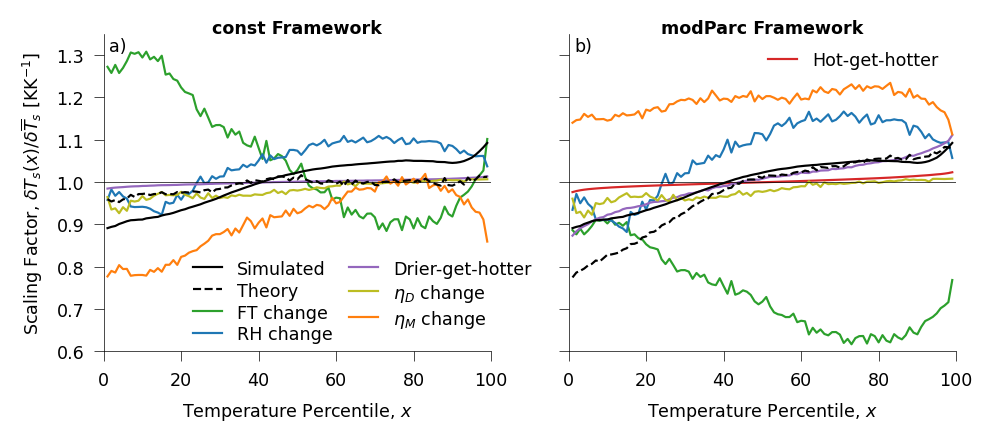

In [115]:
# Ensure when averaging over latitude for each quant, that weight the more convective latitudes more
weights_use = ds_quant.n_const_days.sum(dim='tau_lw')
weights_use = weights_use * lat_weights  # combine with lat weights
# set max to 1 for interpretation i.e. if weight=1 that lat contributes most for that quant
weights_use = weights_use / weights_use.max(dim='lat')

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for key in ['', '_sum']:
    ax[0].plot(ds_sf.quant, ds_sf[f"scale_factor{key}"].weighted(weights_use).mean(dim='lat'),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label=style_map[f"scale_factor{key}"][2], zorder=30)
    ax[1].plot(ds_sf.quant, ds_sf_parc[f"scale_factor{key}"].weighted(weights_use).mean(dim='lat'),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            zorder=30)
# ax.plot(ds_sf_num.quant,
#         np.average(ds_sf_num[f"scale_factor_linear"] + ds_sf_num[f"nl_r_change"] - 1, axis=0, weights=lat_weights),
#         color='k', linestyle='--', label='Linear + nl_r_change')
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.abs(ds_sf[key] - 1).weighted(weights_use).mean(dim='lat')) < 0.015:
        continue
    ax[0].plot(ds_sf.quant, ds_sf[key].weighted(weights_use).mean(dim='lat'), label=style_map[key][2],
            color=style_map[key][0],
            linestyle=style_map[key][1])
for key in ds_sf_parc:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.abs(ds_sf_parc[key] - 1).weighted(weights_use).mean(dim='lat')) < 0.015:
        continue
    ax[1].plot(ds_sf.quant, ds_sf_parc[key].weighted(weights_use).mean(dim='lat'),
               color=style_map[key][0],
               linestyle=style_map[key][1], label=style_map[key][2] if 'temp_surf' in key else None)

update_linewidth(fig)
ax[0].legend(ncol=2, handlelength=leg_handlelength, labelspacing=0.2, columnspacing=0.8, bbox_to_anchor=(1.15, -0.03), loc='lower right')
ax[1].legend(handlelength=leg_handlelength)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(utils.percentile_label)
ax[1].set_xlabel(utils.percentile_label)
ax[0].set_ylabel(utils.sf_label)
label_subplots(fig, ax, box_alpha=0, pos_y=-1,pos_x=2)
ax[0].set_title('const Framework', fontweight='bold', y=0.95)
ax[1].set_title('modParc Framework', fontweight='bold', y=0.95)
update_fontsize(fig)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0.6, 1.35)
# ax[0].legend(ncol=2)
plt.show()
# savefig(fig)

### Deviation from simulated and theoretical estimates
Why do the simulated and theoretical scaling factors differ?
Below, we split it up into neglecting terms in sum of individual mechanisms, and neglecting non-linear combination of mechanisms.

Strong non-linear drier-get-hotter and $\delta \eta_M$ term is because on average $\delta \eta_M<0$ but BL lapse rate constant, hence drier regions which are more on dry lapse rate don't decrease lapse rate as much - more like the drier-get-hotter in the modParc framework.

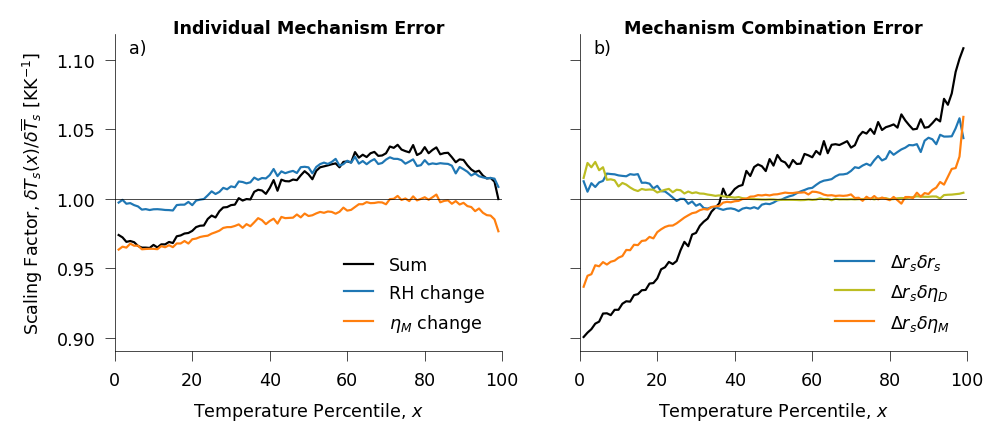

In [116]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
# fig_resize(fig, 10)
ax[0].set_title('Individual Mechanism Error', fontweight='bold', y=0.95)
ax[1].set_title('Mechanism Combination Error', fontweight='bold', y=0.95)
ax[0].plot(ds_sf_num.quant,
           (ds_sf_num['scale_factor_linear'] - ds_sf['scale_factor_sum'] + 1).weighted(weights_use).mean(dim='lat'),
           color='k', label='Sum')
ax[1].plot(ds_sf_num.quant,
           (ds_sf_num['scale_factor_nl']).weighted(weights_use).mean(dim='lat'),
           color='k')

# Plot individual mechanism error
for key in ds_sf:
    if 'scale_factor' in key:
        continue
    if np.nanmax(np.abs(ds_sf[key] - 1).weighted(weights_use).mean(dim='lat')) < 0.02:
        continue
    if np.nanmax(np.abs(ds_sf_num[key] - 1).weighted(weights_use).mean(dim='lat')) > 0.02:
        ax[0].plot(ds_sf.quant, ds_sf_num[key].weighted(weights_use).mean(dim='lat'), label=style_map[key][2],
                   color=style_map[key][0],
                   linestyle=style_map[key][1])

# Plot combination of mechanism error
for key in ds_sf_num:
    if ('nl' not in key) or ('sum' in key) or ('error' in key) or ('scale_factor' in key):
        continue
    if np.nanmax(np.abs(ds_sf_num[key] - 1).weighted(weights_use).mean(dim='lat')) > 0.02:
        # ax[1].plot(ds_sf.quant, ds_sf_num[key].weighted(weights_use).mean(dim='lat'), label=key)
        ax[1].plot(ds_sf.quant, ds_sf_num[key].weighted(weights_use).mean(dim='lat'), label=style_map[key][2],
                   color=style_map[key][0], linestyle=style_map[key][1])


update_linewidth(fig)

# Reorder ax1 legend
handles, labels = ax[1].get_legend_handles_labels()
order = [0, 1, 2, 4, 3, 5]  # desired new order by index
# ax[1].legend([handles[i] for i in order],
#              [labels[i] for i in order], ncol=2, handlelength=leg_handlelength)
ax[1].legend()

ax[0].legend(handlelength=leg_handlelength, loc='lower right')
ax[0].set_xlim(0, 100)
label_subplots(fig, ax, pos_y=-2)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[1].axhline(1, color='k', lw=ax_linewidth)
ax[0].set_xlabel(percentile_label)
ax[1].set_xlabel(percentile_label)
ax[0].set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
update_fontsize(fig)
# ax[0].set_ylim(0.97, 1.03)
plt.show()
# savefig(fig)

In [112]:
# area_weighting(ds_quant.lapse_miy2022_M).mean(dim='lat').isel(tau_lw=0).plot()
# area_weighting(-ds_quant.lapse_miy2022_M).mean(dim='lat').diff(dim='tau_lw').squeeze().plot()